In [1]:
import os
import random
from datetime import datetime
import ast

import gc
import yaml
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter

from preprocessing.final_preprocessing import serve_data, serve_data_sine

from models.transformer_encoder import TransEncoder

from ddpm.ddpm import GaussianDiffusion1D

from evaluation.pca_tsne import visual_evaluation
from evaluation.jsd import plot_jsd
from evaluation.rmse import rmse

gc.collect()

random.seed(42)
np.random.seed(42)

In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [ ]:
config_path = "./config_transcoder.yml"
with open(config_path, 'r') as f:
    config = yaml.full_load(f)

date = datetime.today().strftime('%Y-%m-%d-%H-%M')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = config["seq_len"]
epochs = config["epochs"]
timesteps = config["timesteps"]
batch_size_config = config["batch_size"]
latent_dim = config["latent_dim"]
num_layers = config["num_layers"]
n_heads = config["n_heads"]
beta_schedule = config["beta_schedule"]
objective = config["objective"]
model_name = config["model_name"]
cond_model = config["cond_model"]
lr = float(config["lr"])
betas = tuple_of_floats = ast.literal_eval(config["betas"])
save_rate = int(config["save_rate"])

assert model_name in ["BaseLine", "TransEncoder"], "Chosen  model was not valid, the options are BaseLine or TransEncoder"
assert cond_model in {"mlp", "te", "fft", "stft"}, "Chosen conditioning model was not valid, the options are mlp, te, fft and stft"

log_file_name = "trans_2y_data_kmeans5_10kepochs"
tb_writer = f"./logging/tensorboard/{log_file_name}"

In [ ]:
train_loader, test_loader, train_cols, test_cols, test_data, features, cond_features = serve_data(types=["al"],seq_len=seq_len, batch_size=batch_size_config, kmeans=True, pca=False, overwrite=True, k=5)

Init data shape train:(33984, 4468), test: (33984, 4468)
Number of PCA components: 3530
Number of PCA components: 3530
PCA data shape train:(33984, 3530), test: (33984, 3530)
Adding sequence length
Data shape train:(33973, 12, 3530), test: (8485, 12, 3530)
Transposed data shape train:(33973, 3530, 12), test: (8485, 3530, 12)


e:\OU\master\afstuderen\Thesis\src\preprocessing\final_preprocessing.py:63: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


In [5]:
model = model = TransEncoder(features = features, latent_dim = latent_dim,num_heads = n_heads, num_layers = num_layers, cond_features=cond_features, cond_model=cond_model, device=device, seq_len=seq_len)
    
ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr = lr, betas = betas)
writer = SummaryWriter(tb_writer)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
run_path = f"./logging/weights/{log_file_name}"
os.makedirs(run_path)

rmse_list = []
lowest_loss = 100000
step=0

for running_epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0.0
    for i, (data, cond_data) in enumerate(train_loader):
        data = data.to(device)
        
        cond_data = cond_data.float()
        cond_data = cond_data.to(device)
                
        batch_size = data.shape[0]
        
        optim.zero_grad()
        
        loss = ddpm(data, None)
        loss.backward()
        
        optim.step()
        
        running_loss += loss.item()

        
        if loss.item() < lowest_loss:
            lowest_loss = loss.item()
            best_model_params = model.state_dict()
        
        writer.add_scalar("Batch Training Loss", loss, global_step=step)
        step += 1
    
    avg_epoch_loss = running_loss / len(train_loader)
    writer.add_scalar("Epoch Training Loss", avg_epoch_loss, running_epoch)
    
    if running_epoch % 5 ==0:
        model.eval()        
        with torch.no_grad():
            sample = ddpm.sample(batch_size_config)
        
        p = sample.cpu()
        q = torch.from_numpy(test_data[:batch_size_config])
            
        rmse_res = rmse(p,q).item()
        rmse_list.append(rmse_res)
        
        writer.add_scalar('Epoch Training RMSE', rmse_res, running_epoch)
        
        print(f'Epoch: {running_epoch+1}, Epoch Loss: {avg_epoch_loss:.4f}, RMSE: {rmse_res:.4f}')
    
    else:
        print(f'Epoch: {running_epoch+1}, Epoch Loss: {avg_epoch_loss:.4f}')
            
            
    if running_epoch % save_rate == 0:
        torch.save({
            'epoch': running_epoch+1,
            'diffusion_state_dict': ddpm.state_dict(),
            'diffusion_optim_state_dict': optim.state_dict()
            }, os.path.join(f'{run_path}', f'ep_{running_epoch}_mse_{avg_epoch_loss:.3f}_weights.pth'))

torch.save(best_model_params, os.path.join(f'{run_path}', 'best_model_weights.pth'))

In [ ]:
model.load_state_dict(torch.load(os.path.join(f'{run_path}', 'best_model_weights.pth')))
ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

In [7]:
with torch.no_grad():
    samples = ddpm.sample(batch_size_config)
    samples = samples.cpu().numpy()

print(f"Samples shape: {samples.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:08<00:00, 123.44it/s]


Samples shape: (256, 3530, 12)


In [8]:
real_data_train, real_cond_data_train = next(iter(train_loader))
real_data_test, real_cond_data_test = next(iter(test_loader))

real_cond_data_train.shape, real_data_test.shape

(torch.Size([256, 10, 12]), torch.Size([256, 3530, 12]))

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


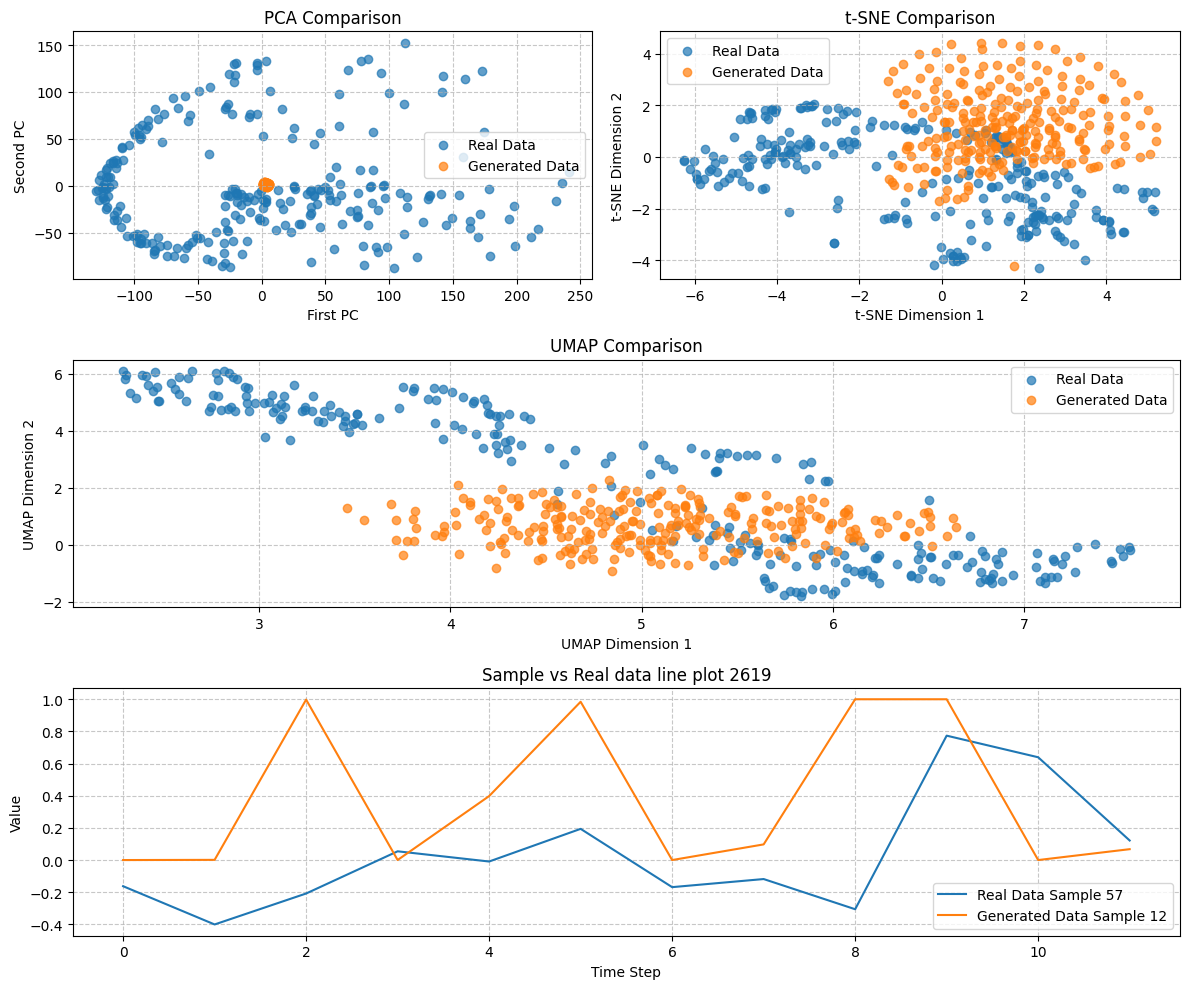

In [9]:
visual_evaluation(real_data_train, samples, log_file_name, False, "train")

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


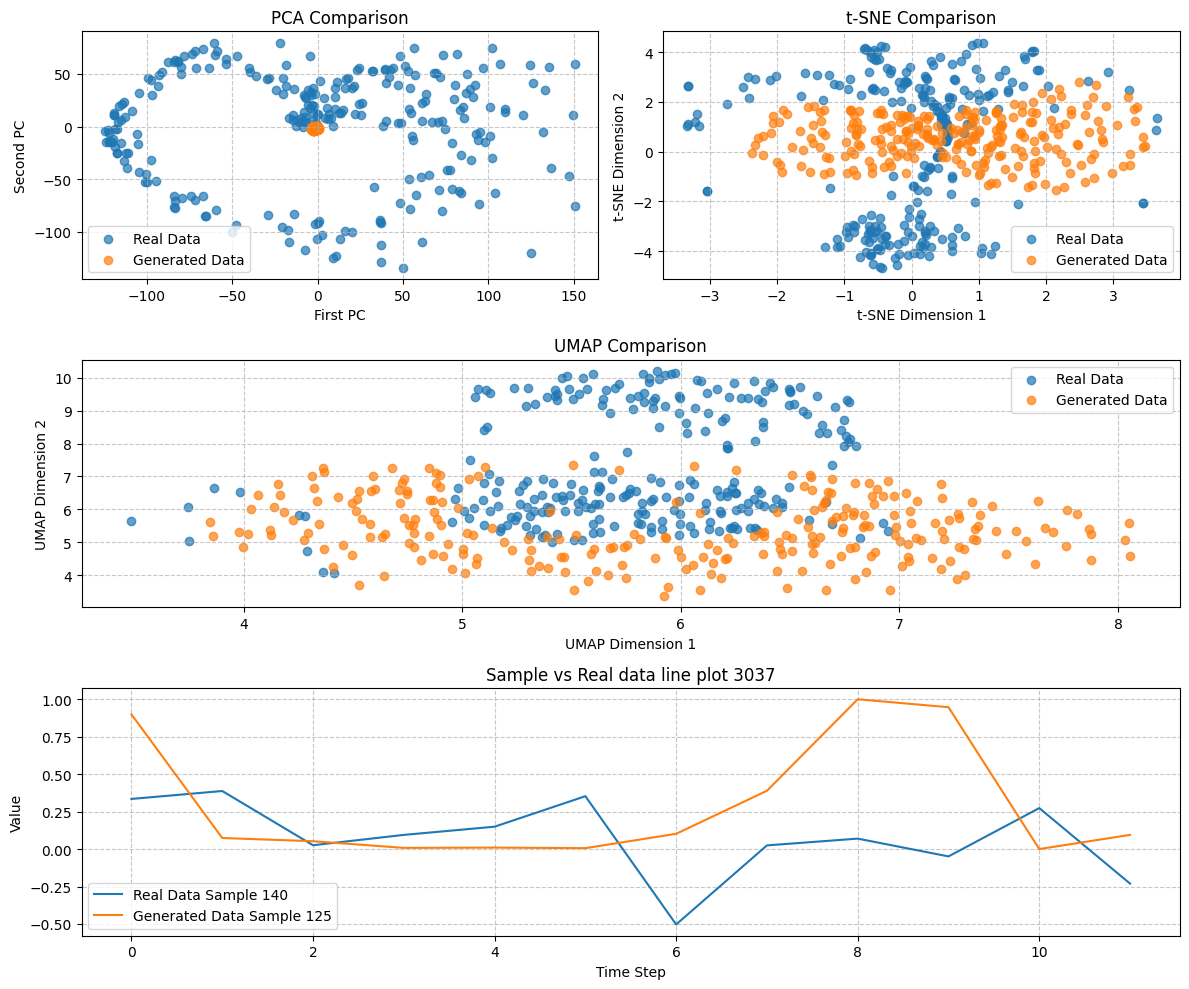

In [10]:
visual_evaluation(real_data_test, samples, log_file_name, False, "test")

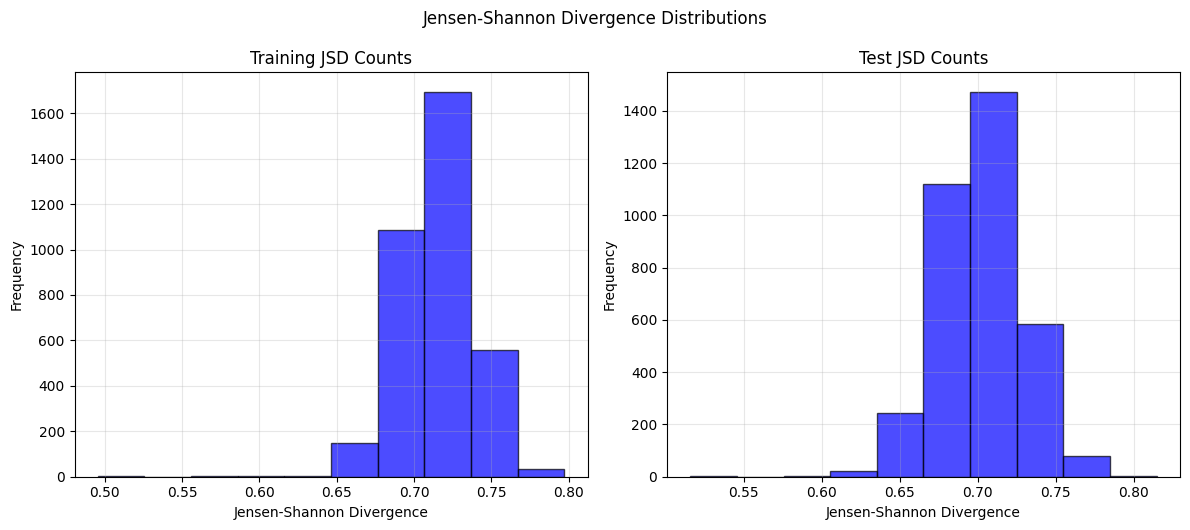

In [11]:
plot_jsd(real_data_train, real_data_test, samples.transpose(0,2,1), log_file_name)

sampling loop time step: 100%|██████████| 1000/1000 [00:02<00:00, 335.51it/s]


Text(0.5, 1.0, 'Real Data')

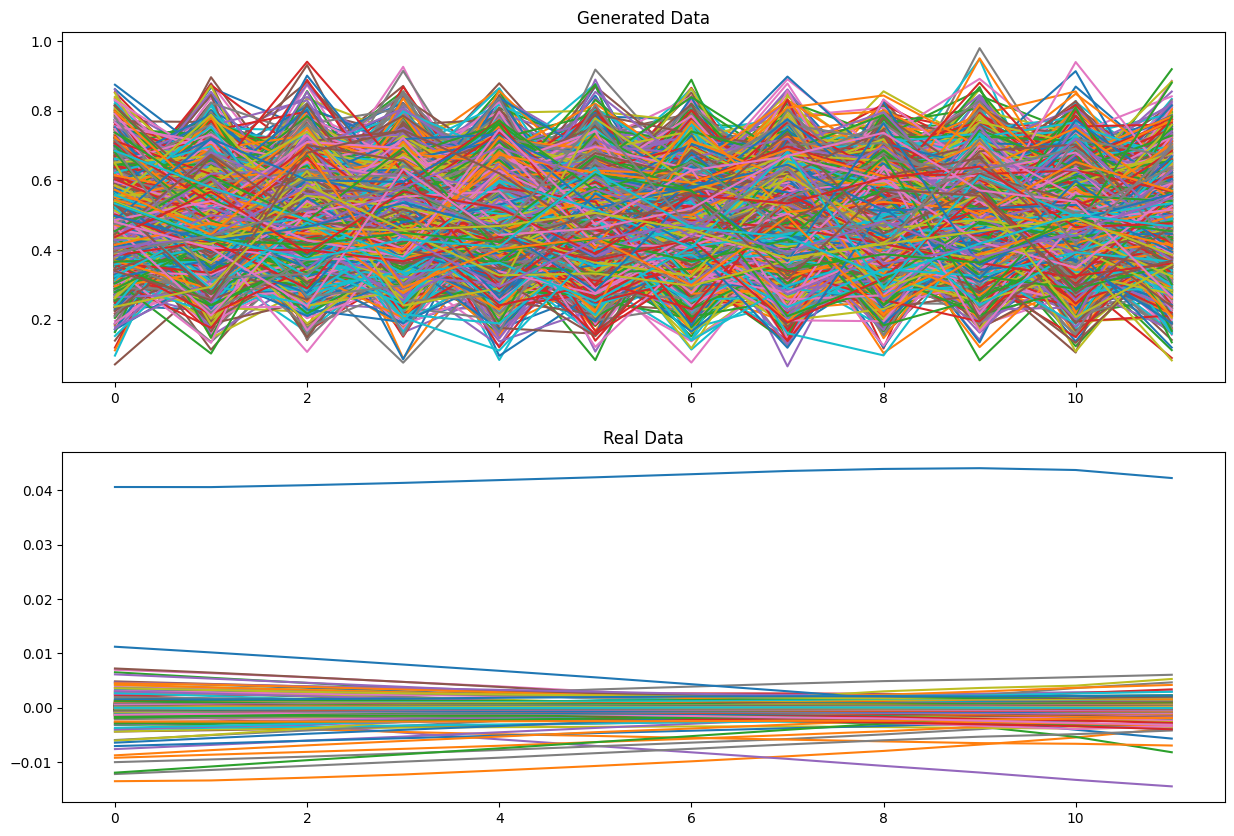

In [12]:
sample_list = []
for i in range(0, 10):
    with torch.no_grad():
        sample = ddpm.sample(1)
        sample = sample.cpu().numpy().squeeze()
    
    sample_list.append(sample)

sample_mean = np.mean(sample_list, axis=0)
gt_mean = test_data.mean(axis=0)

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

for i in range(0, sample_mean.shape[0]):
    axs[0].plot(range(0, sample_mean.shape[1]), sample_mean[i])
    axs[1].plot(range(0, gt_mean.shape[1]), gt_mean[i])

axs[0].set_title("Generated Data")
axs[1].set_title("Real Data")
